## Обработка пропусков

Реальные данные часто содержат много пропущенных значений. Отсутствующие значения могут иметь несколько причин:

* важная причина не отвечать на вопрос / не заполнять данные, т.к. ответ может быть расценен как негатив (__пример:__ сколько просрочек у вас было по кредитам?)

* данных не существует

* данные не собираются из-за человеческой ошибки.

* данные удалены случайно

В любом случае, нам нужно решить эту проблему, прежде чем мы перейдем к моделированию. Также важно отметить, что некоторые алгоритмы, такие как `XGBoost` и `LightGBM`, могут обрабатывать отсутствующие данные без какой-либо предварительной обработки.

<img src="../images/web4_missings.png" width=1000 height=1000 />

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import missingno as msno

In [2]:
train = pd.read_csv("../data/titanic-machine-learning-from-disaster/train-2.csv")
test = pd.read_csv("../data/titanic-machine-learning-from-disaster/test.csv")

print(f'Training data shape: {train.shape}')
print(f'Testing data shape: {test.shape}')

FileNotFoundError: [Errno 2] File b'../data/titanic-machine-learning-from-disaster/test.csv' does not exist: b'../data/titanic-machine-learning-from-disaster/test.csv'

## Целевая переменная

Нам нужно создать модель, которая для каждого пассажира в тестовом наборе предсказывает, выживет ли пассажиры при крушении Титаника. Давайте рассмотрим распределение целевого столбца. Здесь `0` - означает, что пассажир не выжил  и `1` - выжил; очевидно, что меньше людей выжило в аварии.

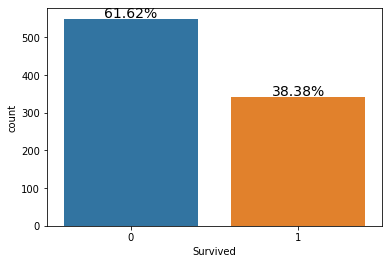

In [3]:
s = sns.countplot(x = 'Survived',data = train)
sizes=[]

for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3, '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14) 

Поскольку основное внимание в этой части урока, мы хотим уделить обнаружению и обработке пропущенных значений, перейдем к нему. Теперь давайте рассмотрим пошаговый процесс управления недостающими значениями в наборе данных.

## Обнаружение отсутствующих значений

### Численное определение недостающих значений

__Первый шаг__ - определить количество / процент пропущенных значений в каждом столбце набора данных. Это даст представление о распределении пропущенных значений.

In [4]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [5]:
train_missing = check_missings(train)
train_missing

Total NA-values = 866


,Age,Cabin,Embarked
Total,177,687,2
Percent,19.8653,77.1044,0.224467
Types,float64,object,object


In [6]:
test_missing = check_missings(test)
test_missing

Total NA-values = 414


,Age,Fare,Cabin
Total,86,1,327
Percent,20.5742,0.239234,78.2297
Types,float64,float64,object


### Обнаружение недостающих данных визуально с помощью библиотеки Missingno

Чтобы графически проанализировать отсутствие данных, воспользуемся библиотекой `missingno`. Это пакет для графического анализа пропущенных значений. Чтобы использовать эту библиотеку, нам нужно импортировать ее следующим образом: `import missingno as msno`

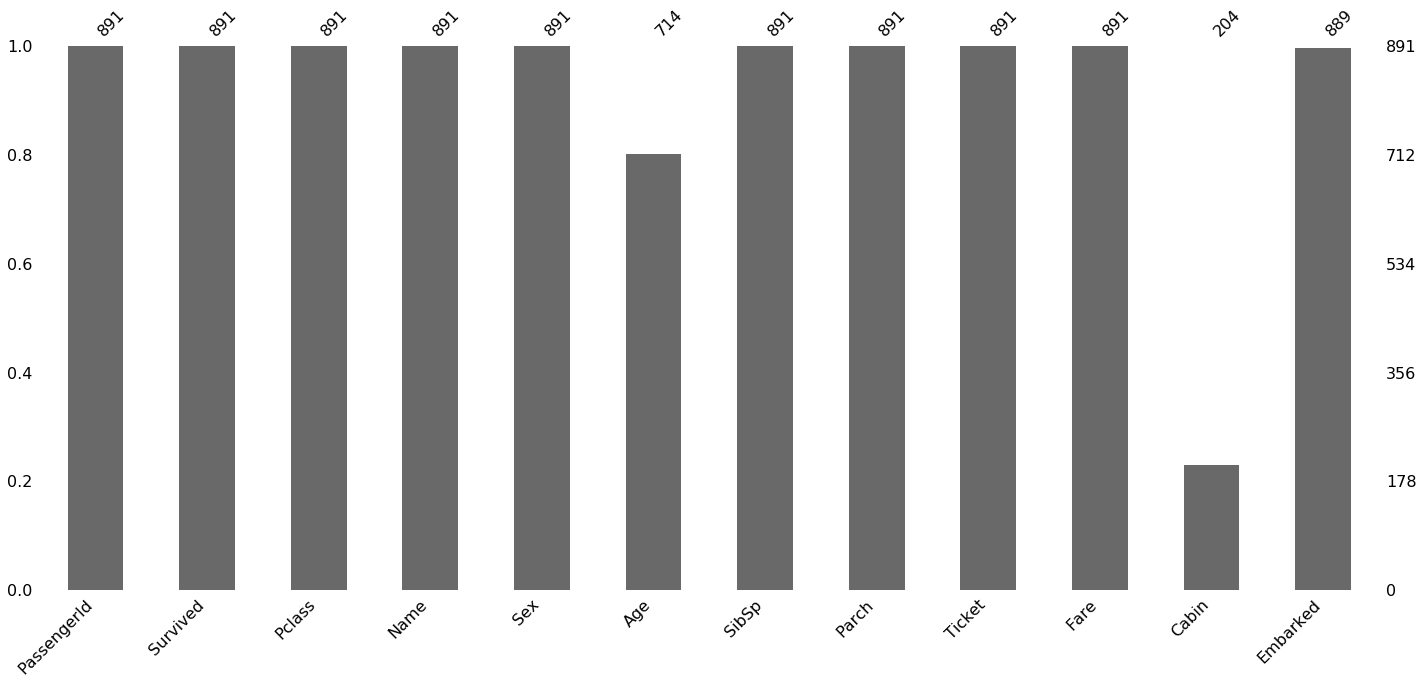

In [7]:
msno.bar(train)

Гистограмма дает краткий графический обзор полноты набора данных. Мы видим, что в столбцах __Age__, __Cabin__ и __Embarked__ отсутствуют значения. Затем имело бы смысл выяснить, где находятся недостающие данные. Матрица `msno.matrix` представляет собой dense-матрицу, которая позволяет быстро визуально определять в каком месте пропущены значения (позволяет ответить на вопрос, есть ли закономерность в пропусках в зависимости от индекса наблюдения).

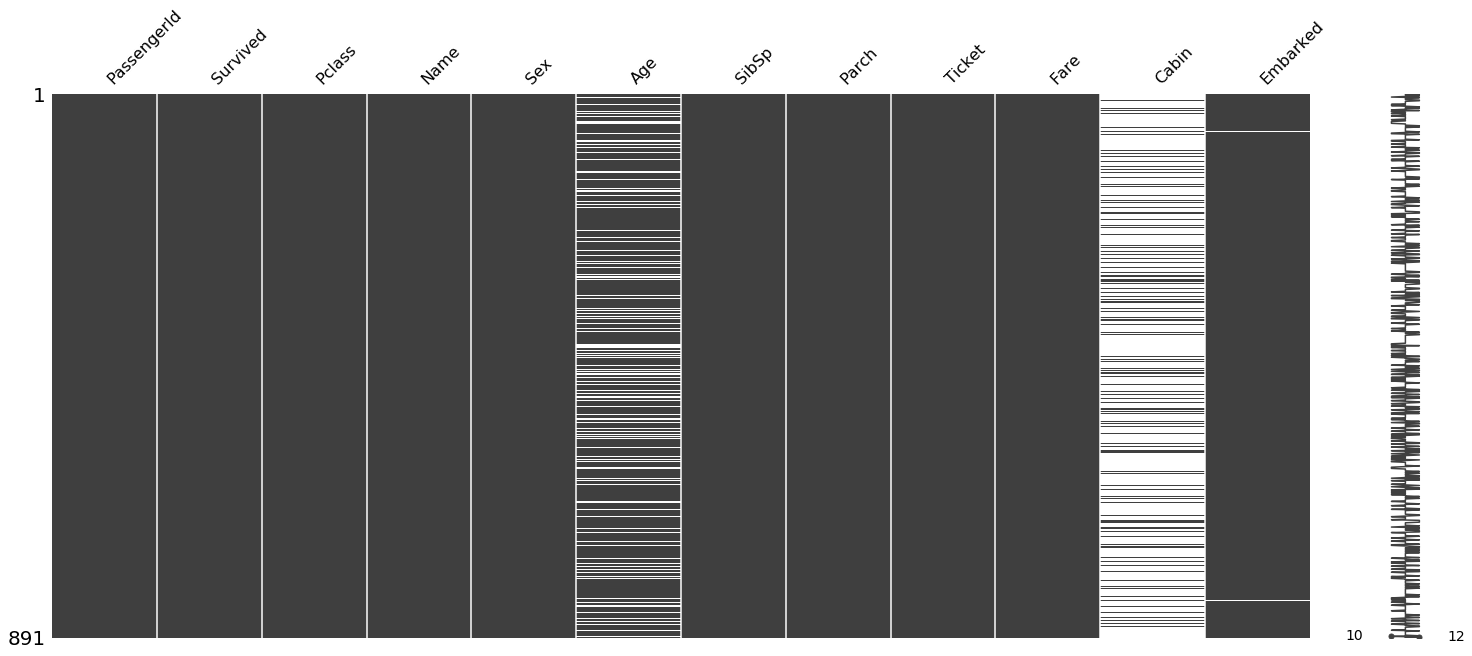

In [8]:
msno.matrix(train)

* График отображается пустым (белым) везде, где отсутствуют значения. Например, в столбце __Embarked__ есть только два примера отсутствующих данных, отсюда две белые линии.

* Спарклайн справа дает представление об общей форме полноты данных и указывает количество столбцов без пропусков (10) и общее количество столбцов (12).

* Также можно извлечь подвыборку из всего набора данных, чтобы определить точное местоположение пропущенных значений. Например, давайте проверим первые 100 строк.

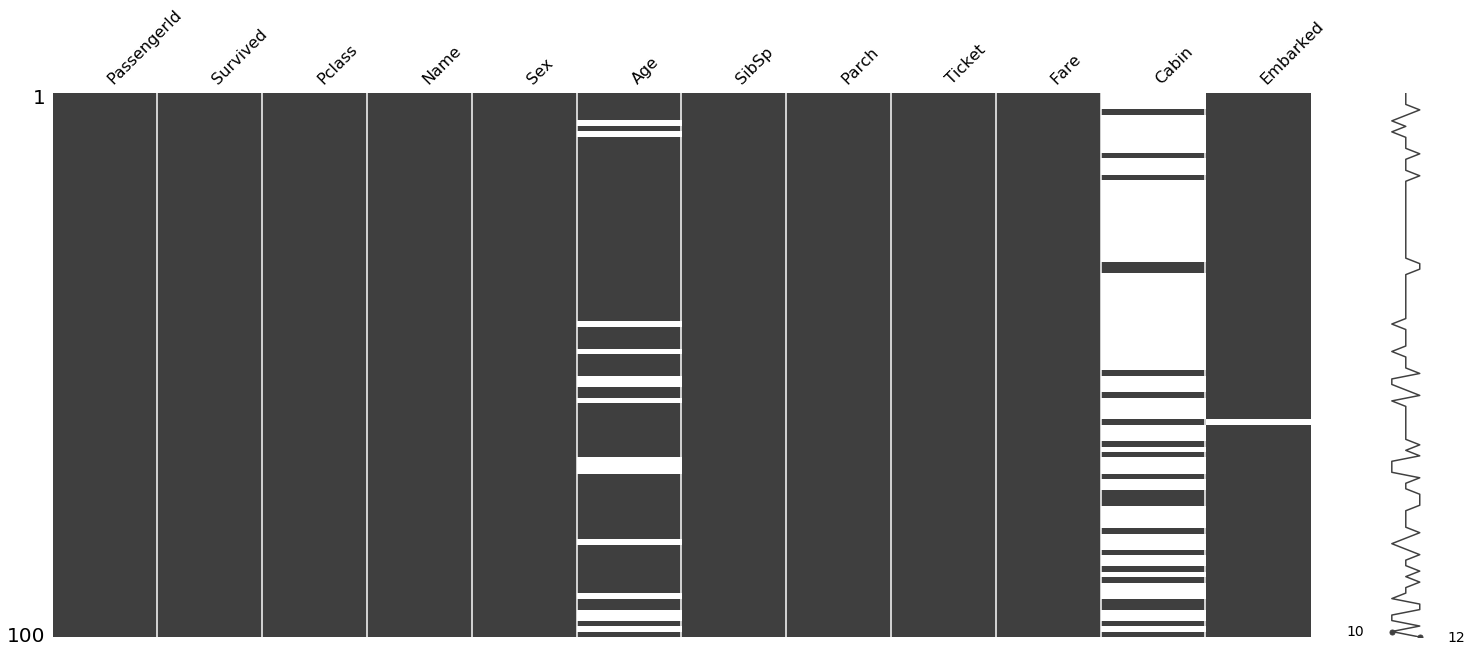

In [9]:
msno.matrix(train.sample(100))

## Причины отсутствующих значений

Прежде чем мы начнем обрабатывать отсутствующие значения, важно понять различные причины отсутствия данных. Причин может быть три:

<img src="../images/web4_missing_reasons.jpg" width=1000 height=1000 />

* __Отсутствует совершенно случайно (MCAR)__ - отсутствующие значения для данной переменной (__`Y`__) не связаны с другими переменными в данном наборе данных или с самой переменной (__`Y`__). Другими словами, для пропущенных значений нет особой причины.


* __Случайно пропавшие (MAR)__ - возникает, когда пропуск не является случайным, но когда отсутствие может быть полностью объяснено переменными, по которым имеется полная информация.


* __Отсутствует не случайно (MNAR)__ - пропуск зависит от ненаблюдаемых данных или от стоимости самих недостающих данных.

## Поиск причины отсутствия данных с помощью msno

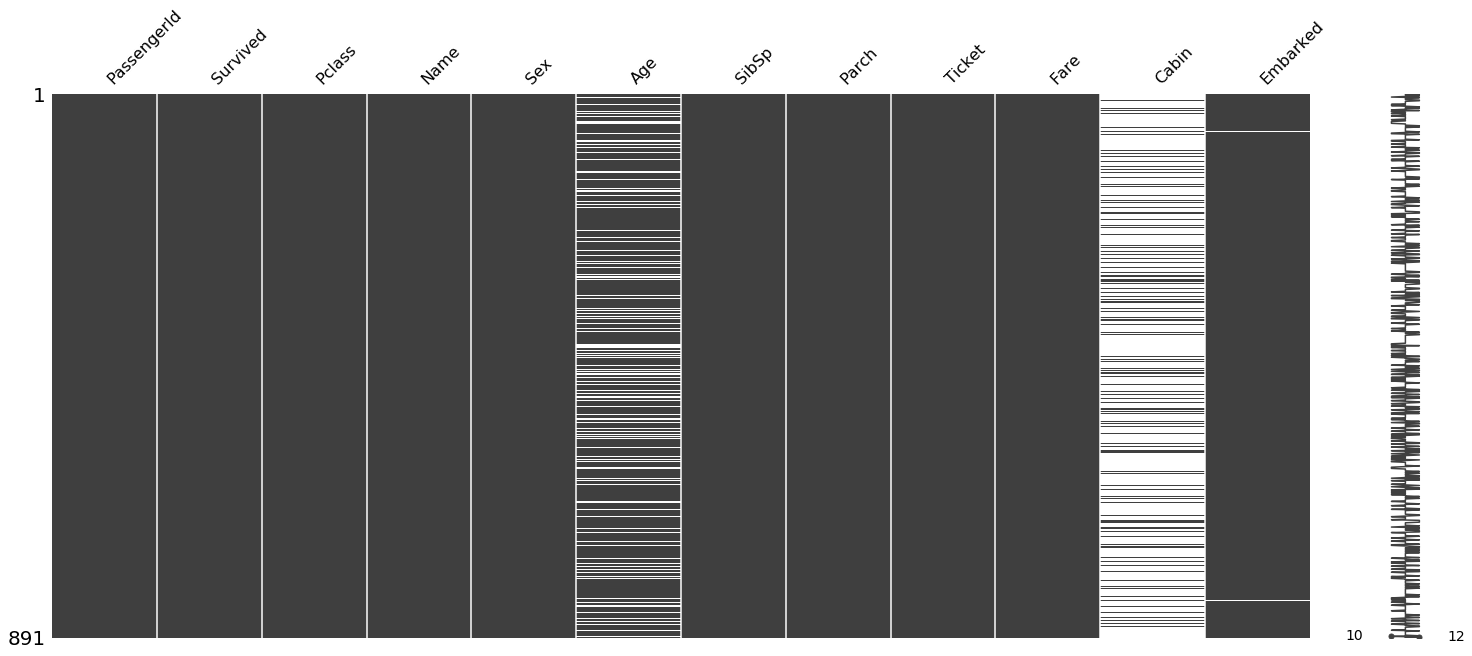

In [10]:
msno.matrix(train)

* Столбец __Embarked__ имеет очень мало пропущенных значений, и, похоже, он не коррелирует с любым другим столбцом. Следовательно, пропуск в столбце __Embarked__ можно отнести к категории «Отсутствуют полностью случайно».


* И в столбцах __Age__, и в столбцах __Cabin__ много пропущенных значений. Это может быть случай MAR, поскольку мы не можем напрямую определить причину отсутствия данных в этих столбцах.

`missingno` также позволяет нам отсортировать график по определенному столбцу. Давайте отсортируем значения по столбцу __Age__ и __Cabin__, чтобы увидеть, есть ли закономерность в пропущенных значениях.

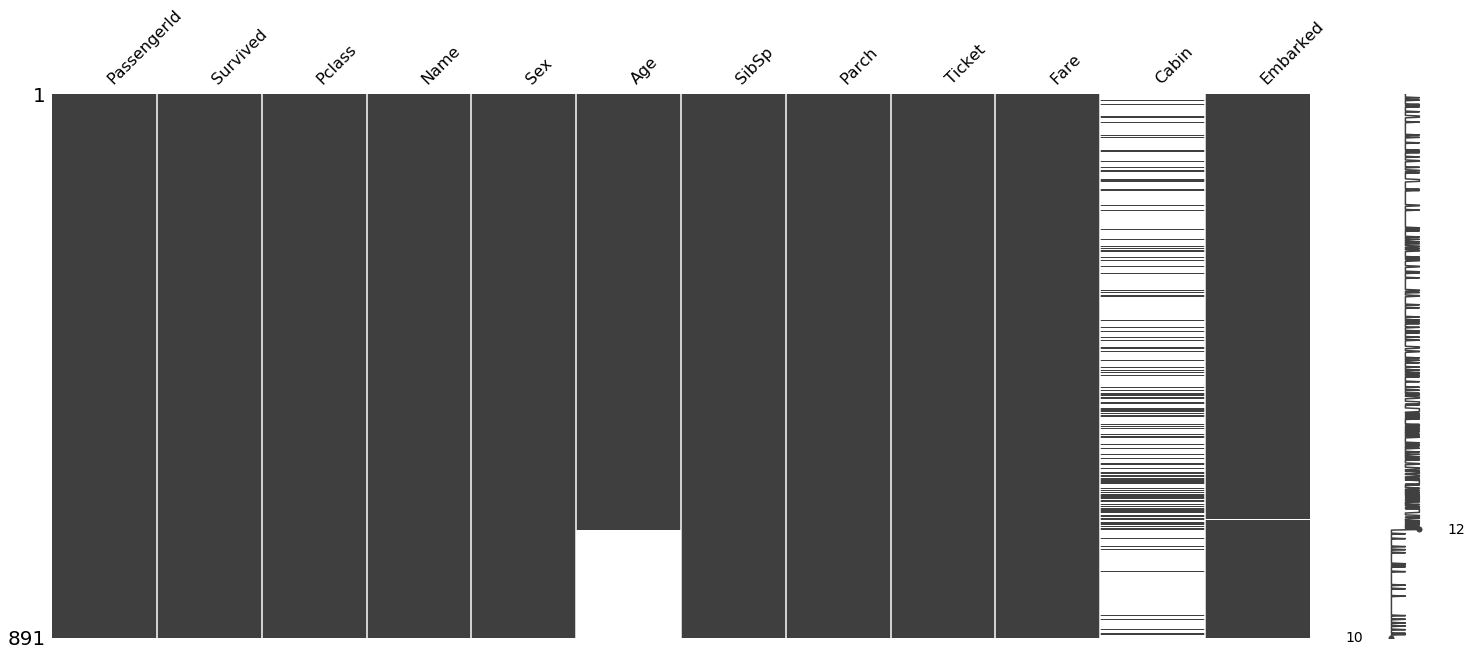

In [11]:
train_sorted_by_age = train.sort_values('Age')
msno.matrix(train_sorted_by_age)

Отсюда ясно, что нет никакой связи между отсутствием в столбце __Age__ и __Cabin__. Чтобы дополнительно закрепить этот вывод, мы также можем визуализировать тепловую карту для разного набора признаков.

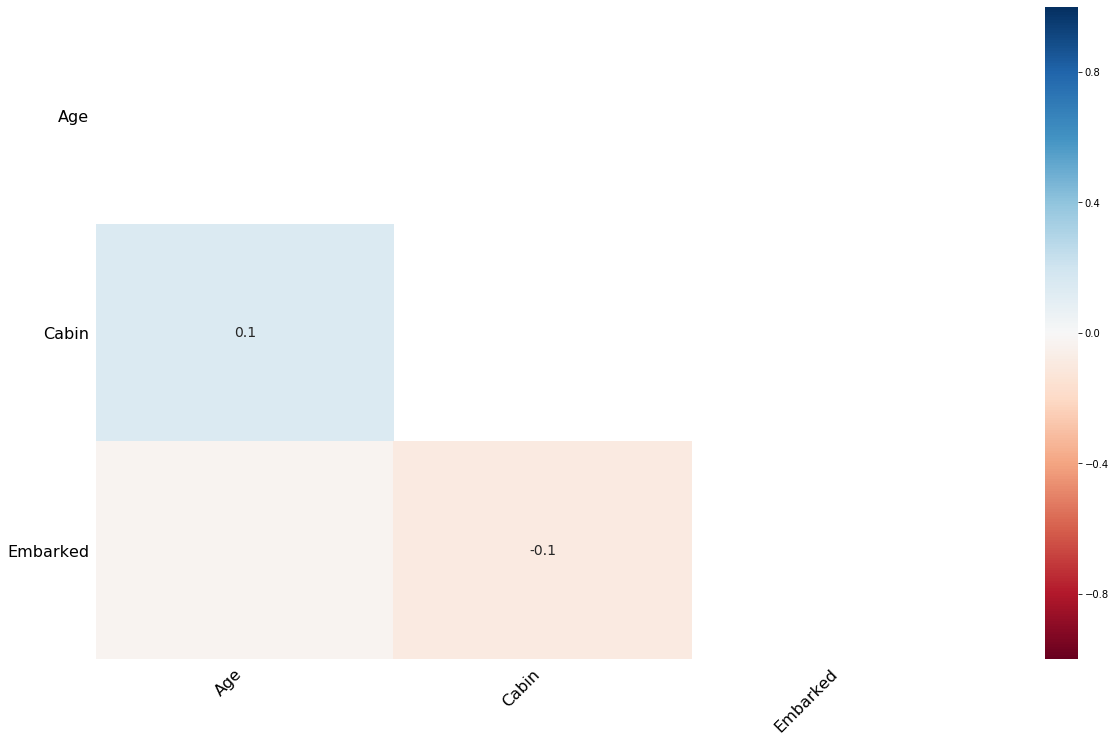

In [12]:
msno.heatmap(train)

Тепловая карта показывает, что нет сильной корреляции между пропусками в разных признаках. Это хорошо; низкие корреляции указывают на то, что пропуски относятся к __MAR__.

## Поиск причины отсутствия данных с помощью дендограммы

Дендограмма - это древовидная диаграмма. Он объединяет сильно коррелированные переменные.

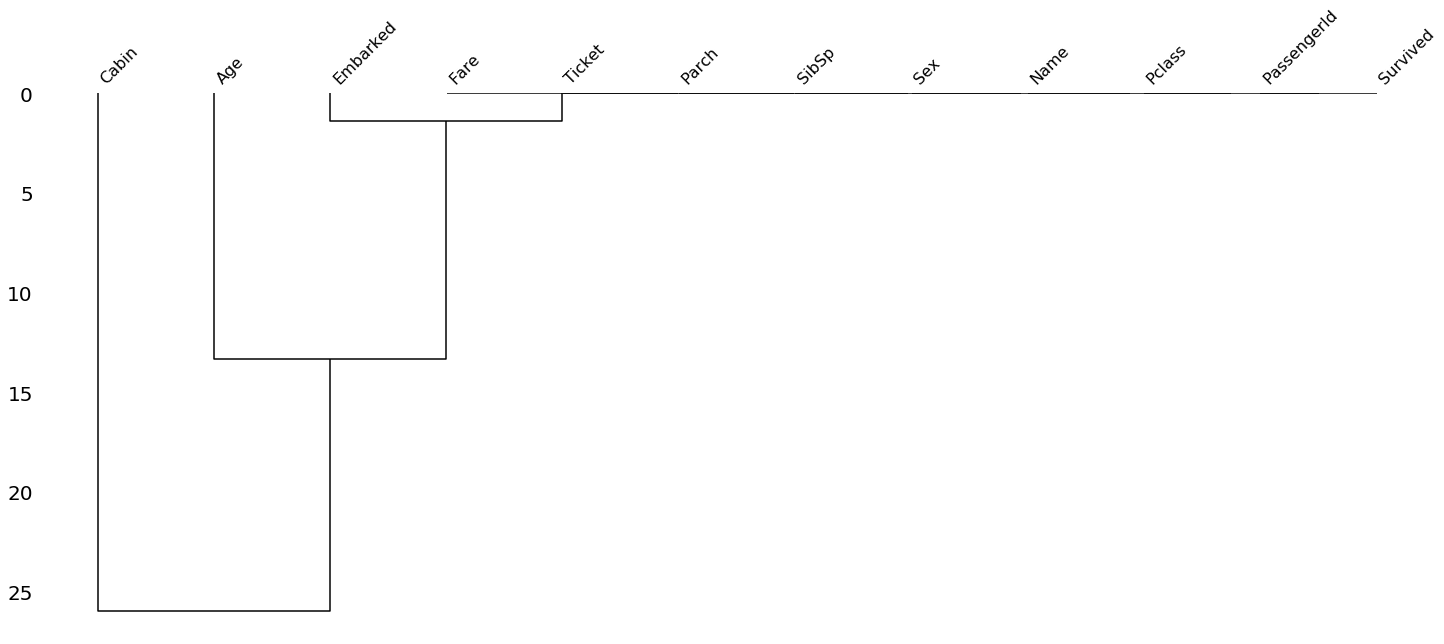

In [13]:
msno.dendrogram(train)

Давайте прочитаем приведенную выше дендрограмму сверху вниз:

* Листья, которые связаны между собой на нулевоq отметке, полностью предсказывают присутствие друг друга - одна переменная всегда может быть пустой, когда другая заполнена, или они всегда могут быть заполнены обе или обе пустыми.


* Пропуски в __Embarked__ обычно больше похоже на __Age__, чем на __Fare__ / __Ticket__. Однако в этом конкретном случае корреляция высока, поскольку в столбце __Embarked__ очень мало пропущенных значений.


## Обработка отсутствующих значений

После выявления закономерностей в пропущенных значенияхб можно присутпать к их обработке.

<img src="../images/web5_missings.png" width=600 height=600/>

__Удаление__ означает удаление недостающих значений из набора данных. Однако это не рекомендуется, так как это может привести к потере информации из набора данных. Мы должны удалять отсутствующие значения из набора данных только в том случае, если их доля очень мала. Кроме того, удаления бывают трех типов:

* парное удаление
* списочное удаление / удаление строк


### Парное удаление

Парное удаление используется, когда значения отсутствуют полностью случайным образом. При попарном удалении удаляются только недостающие значения. Можно корректно применять для `MCAR`.

In [14]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
train_ = train.copy()
train_['Age'].mean()

29.69911764705882

In [16]:
train_ = train_.dropna(subset=["Age"])
train_["Age"].mean()

29.69911764705882

### Списочное удаление / удаление строк

Во время удаления по списку удаляются полные строки, содержащие отсутствующие значения. В результате, такой подход также называется полным удалением. Как и попарное удаление, удаление по списку также используется только для значений `MCAR`.

In [19]:
train_ = train.dropna(subset=["Age"], how="any")
train_["Age"].isnull().sum()

0

В столбце __Age__ нет пропущенных значений. Основным недостатком удаления по списку является то, что большая часть данных и, следовательно, большая часть информации теряется. Рекомендуется использовать его только тогда, когда количество пропущенных значений очень мало.

### Удаление полных столбцов

Если в столбце много пропущенных значений, скажем, более 90%, и признак не значимый, можно целиком удалить этот признак. Однако, опять же, это не лучшая методика удаления данных.


## Заполнение пропусков

<img src="../images/web5_missing_imputers.png" width=600 height=600/>

Существует множество способов вменения недостающих значений в зависимости от характера задачи и данных.

### Базовые способы замены пропусков

* замена на константну
* замена с использованием статистики (среднее, медиана или мода) для каждого столбца, в котором встречаются пропуски;
* для таких способов замены пропусков можно использовать класс `SimpleImputer` из `sklearn`

In [25]:
from sklearn.impute import SimpleImputer
train_constant = train.copy()

In [26]:
mean_imputer = SimpleImputer(strategy='constant')
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [28]:
train_most_frequent = train.copy()
mean_imputer = SimpleImputer(strategy='most_frequent')
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)
train_most_frequent.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Способы замены пропусков в задаче с временной зависимостью

Теперь давайте рассмотрим способы замены пропущенных значений в типичной задаче временных рядов. Решение проблемы пропущенных значений в задаче с временной зависимостью немного отличается. Метод `fillna()` используется для подстановки пропущенных значений в таких задачах. Основные методы замены пропусков:

* `ffill` или `pad` - заменить `NaN` последним наблюдаемым значением


* `bfill` или `backfill` - заменить `NaN` следующим наблюдаемым значением


* Метод линейной интерполяции



In [87]:
data = pd.read_csv(
    "data/sberbank-russian-housing-market/train.csv", parse_dates=['timestamp']
)
data.head(n=2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000


In [88]:
data_missing = check_missings(data)
data_missing

Total NA-values = 261026


,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,preschool_quota,school_quota,...,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,prom_part_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000
Total,6383,167,9572,9572,13605,9572,9572,13559,6688,6685,...,1725,1725,1725,991,991,991,178,297,297,297
Percent,20.9478,0.548062,31.4135,31.4135,44.649,31.4135,31.4135,44.498,21.9487,21.9389,...,5.66112,5.66112,5.66112,3.25227,3.25227,3.25227,0.584162,0.974697,0.974697,0.974697
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Имеется много пропущенных значений, а в некоторых столбцах, таких как __floor__ и __build_year__ (и другие), отсутствует более 50% значений. Давайте теперь посмотрим, как мы можем заменить эти недостающие значения.

In [89]:
data = data.sort_values(by=["full_sq", "timestamp"])
mean_stat, std_sts = data.mean(), data.std()
data.head(n=2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
17932,17935,2014-04-28,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,7,1,0,12,1,4425000
24296,24299,2014-11-05,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0,...,1,1,0,2,12,0,1,10,0,8167508


In [90]:
data_ffill = data.copy()
data_ffill = data_ffill.fillna(method="ffill")
mean_stat_ffill, std_stat_ffill = data_ffill.mean(), data_ffill.std()

In [91]:
data_bfill = data.copy()
data_bfill = data_bfill.fillna(method="bfill")
mean_stat_bfill, std_stat_bfill = data_bfill.mean(), data_bfill.std()

Text(0, 0.5, 'delta in mean-values')

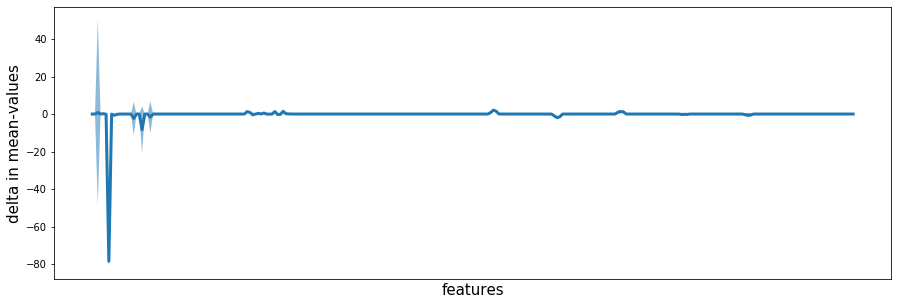

In [92]:
fig = plt.figure(figsize=(15, 5))
std_stat = std_stat_ffill - std_stat_bfill
mean_stat = mean_stat_ffill - mean_stat_bfill
plt.plot(stat, linewidth=3)
plt.fill_between(
    x=range(stat.shape[0]),
    y1=mean_stat-std_stat,
    y2=mean_stat+std_stat,
    alpha=0.5
)
plt.xticks([])
plt.xlabel("features", size=15)
plt.ylabel("delta in mean-values", size=15)

## Линейная интерполяция

Временные ряды могут сильно изменяться во времени. Следовательно, вместо использования `ffill` и `bfill` - не самое лучшее решение проблемы пропущенного значения. Более подходящей альтернативой было бы использование методов интерполяции, при которых значения заполняются увеличивающимися или уменьшающимися значениями.

__Линейная интерполяция__ - это метод заполнения пропусков, который предполагает линейную взаимосвязь между наблюдениями и использует непропущенные значения из соседних наблюдений для вычисления значения для отсутствующих наблюдений. Существует большое количество стратегий использования интерполяции. Описание тут: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

In [93]:
data_inter = data.sort_values(by=["timestamp"]).copy()
data_inter.interpolate(method="linear", limit_direction="both", inplace=True)
mean_stat_inter, std_stat_inter = data_inter.mean(), data_inter.std()

## Методы заполнения пропусков на основе ML

В более продвинутых методах заполнения пропусков используются алгоритмы машинного обучения. В отличие от предыдущих методов, в которых мы использовали другие значения столбцов для прогнозирования пропущенных значений. В этом разделе мы рассмотрим следующие две техники:

* Nearest neighbors imputation


* Multivariate feature imputation

### Замена пропусков с помощью KNN

Класс `KNNImputer` обеспечивает заполнение пропущенных значений с использованием метода k-ближайших соседей. Каждый отсутствующий признак заполняется с использованием значений из `n_neighbors` ближайших соседей, которые имеют значение для этого признака. Характеристики соседей усредняются равномерно или взвешиваются по расстоянию до каждого соседа.

In [98]:
from sklearn.impute import KNNImputer
data_knn = data.copy(deep=True)

In [99]:
knn_imputer = KNNImputer(n_neighbors=25, weights="uniform")
data_knn["life_sq"] = knn_imputer.fit_transform(data_knn[["life_sq"]])

## Многомерная импутация пропусков посредством связанных уравнений (MICE)

Стратегия заполнения пропущенных значений путем моделирования каждого признака с пропущенными значениями в зависимости от других функций в циклическом стиле. Этот подход использует несколько множественный регрессий по случайной выборке данных, затем берет среднее из значений множественной регрессии и использует это значение для заполнения пропущенного значения. В `sklearn` это реализовано следующим образом:

In [101]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [103]:
data_mice = data.copy(deep=True)

mice_imputer = IterativeImputer()
data_mice["life_sq"] = mice_imputer.fit_transform(data_mice[["life_sq"]])

## Алгоритмы, которые умеют в обработку пропусков

Некоторые алгоритмы, такие как `XGBoost`, `LightGBM`, `CatBoost` могут обрабатывать отсутствующие значения без какой-либо предварительной обработки, предоставляя соответствующие параметры.

__`XGBoost`__

<img src="../images/web5_xgb_missings.png" width=800 height=600/>

__`LightGBM`__

<img src="../images/web5_lgb_missings.png" width=800 height=600/>